In [1]:
import functools
import sys
import math
import scipy.io
sys.path.append("..")
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

import Test_Likelihood as tl
import ODE_Dynamics as od
import Positive_Symptom_fn as fn

from functools import partial

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
data = scipy.io.loadmat('../data/test_data_simulation.mat')
x = tf.cast(data['data_simulation'],dtype = tf.float32)
test_data = np.reshape(
      x, x.shape)
test_data = tf.transpose(test_data)[0:10,]
#print(test_data[0:10,])

In [3]:
# Joint log-likelihood

def joint_log_prob(test_data, R0):
    vdyn_ode_fn = od.ViralDynamics
    positive_fn = fn.proba_pos_sym(170306.4 * 1E-5).positive_fn
    symptom_fn = fn.proba_pos_sym(170306.4 * 1E-5).symptom_fn
    prob_s_ibar = 0.1
    mu_b, sigma_b = 5, 1
    beta = np.random.normal(mu_b, sigma_b, 1)
    L = 0.0025/beta
    V0 = 1E3
    X0 = 1E6
    Y0 = V0
    par=tf.constant(np.array([[L,0.01,beta*1E-7,0.5,20,10, V0, X0, Y0]], dtype=np.float32))
    vpar = par
    pospar = par
    sympar = par
    sample_size = 1166
    k = 1
    index = 1
    mu_b, sigma_b = 5, 1
    beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
    L = 0.0025/beta
    par=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
    V0 = np.random.normal(1E3, 1E2, 1)
    X0 = 1E6
    Y0 = V0
    init_state=(np.array([[V0,X0,Y0]], dtype=np.float32))

    while index <= sample_size - 1:
        beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
        L = 0.0025/beta
        par_new=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
        par = np.concatenate((par, par_new), axis = 0)
        V0 = np.random.normal(1E3, 1E2, 1)
        X0 = 1E6
        Y0 = V0
        init_state_new=(np.array([[V0,X0,Y0]], dtype=np.float32))
        init_state = np.concatenate((init_state, init_state_new), 0)

        index +=1
        

    vpar = tf.constant(par, dtype=tf.float32)
    pospar = par
    sympar = par

    epipar = tf.constant(np.array([[R0, 5.0E-08,0.1, 0.001, 0.999]], dtype=np.float32))

    loglike = tl.loglik(test_data, vdyn_ode_fn, positive_fn, symptom_fn, prob_s_ibar, prob_fp=0.0, Epi_Model=od.SIR,
                 duration= 20.0, Epi_cadence=0.5, Vir_cadence=0.0625)
    ll,pp = loglike.__call__(test_data, epipar, vpar, pospar, sympar)
    ll = ll - math.log(R0)
    return ll


In [4]:
joint_log_prob(test_data, R0 = 1.8)

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=-341.13504>

In [5]:
# Compute log_lik 
# Impute things we don't want to sample, eg. observations

unnormalized_posterior_log_prob = partial(joint_log_prob, test_data)


In [6]:
# Initialize parameters
r0 = 1.8
# nu0 = 0.1; i0 = 0.001; s0 = 0.999
initial_state = [r0]
#, nu0, i0, s0]

In [7]:
# Transform all parameters so that parameter spaces are unconstrained
# Every parameter needs a bijector, might be 'Identity'
unconstraining_bijectors = [
    tfb.Log()
]
#    tfb.Invert(tfb.Sigmoid()),
#    tfb.Invert(tfb.Sigmoid()
#    ]

In [8]:
#@tf.function(autograph=False)
def sample():
    return tfp.mcmc.sample_chain(
        num_results = 1000,
        num_burnin_steps = 500,
        current_state = initial_state,
        kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn = unnormalized_posterior_log_prob,
                     step_size = 0.065,
                     num_leapfrog_steps = 2),
                bijector = unconstraining_bijectors),
             num_adaptation_steps = 400),
        trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

In [9]:
[R0], is_accepted = sample()
# [R0, nu, i, s]

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Tensor(10.0, shape=(), dtype=float32)
initial time
0.0
final time
tf.Ten

In [22]:
# Compute posterior means of Epidemic parameters

acceptance_rate = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32)).numpy()
mean_R0 = tf.reduce_mean(R0, axis=0).numpy()
#mean_nu = tf.reduce_mean(nu, axis=0).numpy()


In [23]:
print('acceptance_rate:', acceptance_rate)
print('avg basic reproduction number:', mean_R0)
#print('avg recovery rate:', mean_nu)
#print('avg infected', mean_i)
#print('avg susceptible', mean_s)

acceptance_rate: 0.653
avg basic reproduction number: 1.5614125


In [25]:
print(len(R0))

1000


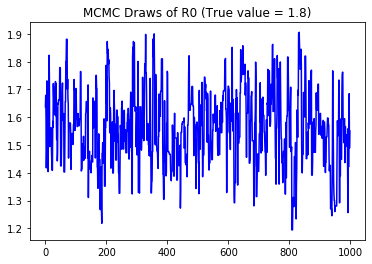

In [13]:
import matplotlib.pyplot as plt
t = list(range(len(R0)))
plt.plot(t, R0.numpy(), "b-")
plt.title("MCMC Draws of R0 (True value = 1.8)")
plt.savefig('mcmc_plot_R0.png', dpi=300, bbox_inches='tight')